In [1]:
import importlib
import theano.tensor as T
import sys, os
sys.path.append("/home/bl3/PycharmProjects/GeMpy/GeMpy")
sys.path.append("/home/bl3/PycharmProjects/pygeomod/pygeomod")
sys.path.append("/home/miguel/PycharmProjects/GeMpy/GeMpy")
import GeoMig
#import geogrid
#importlib.reload(GeoMig)
importlib.reload(GeoMig)
import numpy as np
import pandas as pn
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
from skimage import measure

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
np.set_printoptions(precision = 2, linewidth= 130, suppress =  True)
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib notebook


Using gpu device 0: GeForce GTX 970 (CNMeM is disabled, cuDNN not available)


# Sandstone Model

First we make a GeMpy instance with most of the parameters default (except range that is given by the project). Then we also fix the extension and the resolution of the domain we want to interpolate. Finally we compile the function, only needed once every time we open the project (the guys of theano they are working on letting loading compiled files, even though in our case it is not a big deal).

*General note. So far the reescaling factor is calculated for all series at the same time. GeoModeller does it individually for every potential field. I have to look better what this parameter exactly means*

In [6]:
sandstone = GeoMig.Interpolator(range_var = np.float32(110000),
                               u_grade = 9) # Range used in geomodeller

# Setting the extent and resolution of the grid
sandstone.set_extent(696000,747000,6863000,6950000,-50000, 2000)
sandstone.set_resolutions(40,40,40)
sandstone.create_regular_grid_3D()

sandstone.theano_compilation_3D()


/home/miguel/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: DeprecationWarning: stack(*tensors) interface is deprecated, use stack(tensors, axis=0) instead.


## Loading data from geomodeller

So there is four series, 3 of one single layer and 1 with 2. Therefore we need 4 potential fields, so lets begin.

In [7]:
sandstone.load_data_csv("foliations", os.pardir+"/input_data/a_Foliations.csv")

sandstone.load_data_csv("interfaces", os.pardir+"/input_data/a_Points.csv")


#sandstone.Interfaces[sandstone.Interfaces["formation"] =="EarlyGranite"]
pn.set_option('display.max_rows', 25)


### Defining Series

In [8]:
sandstone.set_series({"EarlyGranite_Series":sandstone.formations[-1], 
                      "BIF_Series":(sandstone.formations[0], sandstone.formations[1]),
                      "SimPleMafic_Series":sandstone.formations[2]})
sandstone.series

{'BIF_Series': ('SimpleMafic2', 'SimpleBIF'),
 'EarlyGranite_Series': 'EarlyGranite',
 'SimPleMafic_Series': 'SimpleMafic1'}

##  Early granite

I am in 1
The serie formations are EarlyGranite


<IPython.core.display.Javascript object>


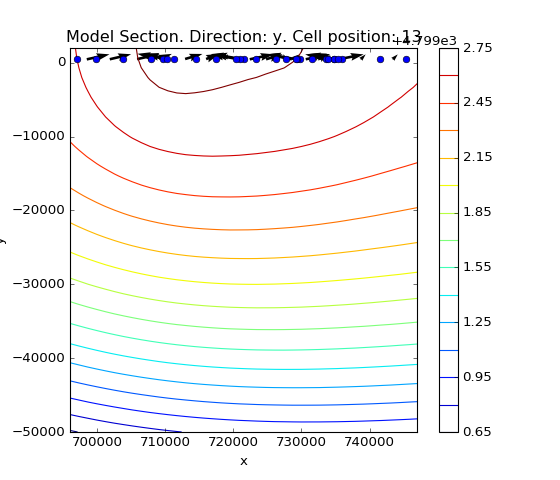

In [9]:
sandstone.compute_potential_field("EarlyGranite_Series", verbose = 1)
sandstone.plot_potential_field_2D(direction = "y", cell_pos = 13, figsize=(7,6), contour_lines = 20)

## BIF Series

I am in 2
The serie formations are SimpleMafic2|SimpleBIF


<IPython.core.display.Javascript object>


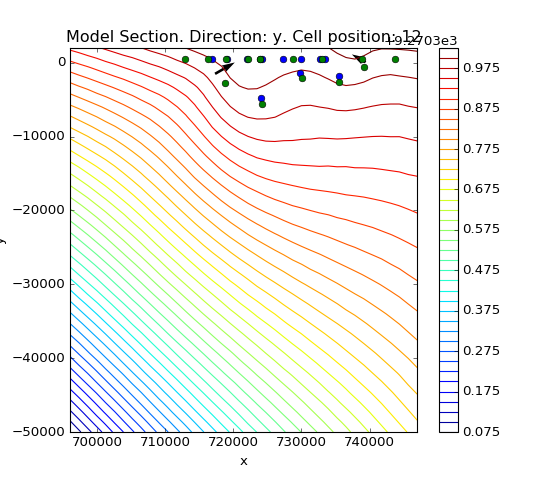

In [10]:
sandstone.rescaling_factor.set_value(48727)
sandstone.u_grade.set_value(9)
#sandstone.theano_compilation_3D()
sandstone.compute_potential_field("BIF_Series", verbose=1)
sandstone.plot_potential_field_2D(direction = "y", cell_pos = 12, figsize=(7,6), contour_lines = 40)

##  SImple mafic

I am in 1
The serie formations are SimpleMafic1


<IPython.core.display.Javascript object>


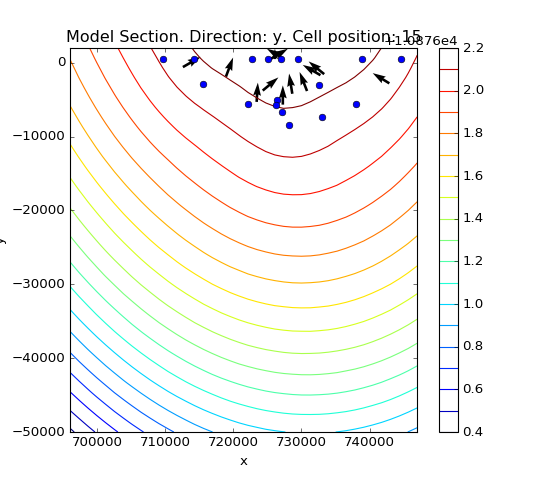

In [11]:
sandstone.compute_potential_field("SimPleMafic_Series", verbose = 1)
sandstone.plot_potential_field_2D(direction = "y", cell_pos = 15, figsize=(7,6), contour_lines = 20)

In [14]:
sandstone.Z_x, sandstone.grid, sandstone.layers

(array([ 10876.16,  10876.22,  10876.29, ...,  10877.18,  10877.19,  10877.19]),
 array([[  696000.  ,  6863000.  ,   -50000.  ],
        [  696000.  ,  6863000.  ,   -48666.67],
        [  696000.  ,  6863000.  ,   -47333.33],
        ..., 
        [  747000.  ,  6950000.  ,     -666.67],
        [  747000.  ,  6950000.  ,      666.67],
        [  747000.  ,  6950000.  ,     2000.  ]], dtype=float32),
 array([[715522.708428, 6891941.417769, -2810.185309],
        [722100.017223, 6891939.776110001, -5640.110309000001],
        [728133.723035, 6891938.27013, -8458.173309],
        [733022.378883, 6891937.049949001, -7358.592309000001],
        [737972.021729, 6891935.814546, -5589.549309],
        [726443.009736, 6905713.435698, -5023.656995],
        [727109.3352020001, 6886862.614432001, -6720.406176],
        [726266.236469, 6901753.8156550005, -5708.065297],
        [732617.810926, 6902964.017319, -3068.116297],
        [709728.25, 6885850.5, 532.9365769999999],
        [714271.063,

In [37]:
%%timeit
_aux_rest_layer_points = sandstone.grid
_aux_ref_layer_points = sandstone.layers.astype("float")

dist = np.sqrt((_aux_ref_layer_points ** 2).sum(1).reshape((_aux_ref_layer_points.shape[0], 1)) +
(_aux_rest_layer_points ** 2).sum(1).reshape((1, _aux_rest_layer_points.shape[0])) -
2 * _aux_ref_layer_points.dot(_aux_rest_layer_points.T))

dist.argmin(axis = 1), sandstone.Z_x[dist.argmin(axis = 1)]

100 loops, best of 3: 10.9 ms per loop


In [41]:
_aux_rest_layer_points = sandstone.grid
_aux_ref_layer_points = sandstone.layers.astype("float")[0]

dist = (abs(_aux_rest_layer_points-_aux_ref_layer_points))

dist.argmin(), sandstone.Z_x[dist.argmin()]

(1561, 10875.668646792305)

In [39]:
sandstone.Z_x[dist.argmin(axis = 1)]

array([ 10878.15,  10878.2 ,  10878.16,  10878.17,  10878.2 ,  10878.17,  10878.17,  10878.19,  10878.18,  10878.2 ,  10878.21,
        10878.19,  10878.19,  10878.16,  10878.21,  10878.18,  10878.16])

### Choosing important isovalues to plot

In [88]:
b = interpolator.geoMigueller(dips,dips_angles,azimuths,polarity, rest, ref,0.1,-0.33333,-3*(-0.3333),0.8557,8.557,1)[0]
arg1,h1 = np.argmin((abs(interpolator.grid - ref[0])).sum(1)), b[np.argmin((abs(interpolator.grid - ref[0])).sum(1))]
arg2, h2 =np.argmin((abs(interpolator.grid - ref[1])).sum(1)), b[np.argmin((abs(interpolator.grid - ref[1])).sum(1))]

### Plotting potential field

In [89]:
"""
xmin = layers[:,0].min()
xmax = layers[:,0].max()
ymin = layers[:,1].min()
ymax = layers[:,1].max()
zmin = layers[:,2].min()
zmax = layers[:,2].max()
"""
nx = 50
ny = 50
nz = 50
dx = (xmax-xmin)/nx
dy = (ymax-ymin)/ny
dz = (zmax-zmin)/nz

#Genereting a regular grid
interpolator.create_regular_grid_3D(xmin,xmax,ymin,ymax,zmin,zmax,nx,ny,nz)
interpolator.theano_set_3D_nugget_degree0()

val = interpolator.geoMigueller(dips,dips_angles,azimuths,polarity, rest, ref,0.1,-0.33333,-3*(-0.3333),0.8557,8.557,1)[0]

G_x, G_y, G_z = interpolator.geoMigueller(dips,dips_angles,azimuths,polarity, rest, ref,0.1,-0.33333,-3*(-0.3333),0.8557,8.557,1)[-3:]

sol_early_granite = val.reshape(50,50,50,
    order = "C")


arg1,h1 = np.argmin((abs(interpolator.grid - ref[0])).sum(1)), val[np.argmin((abs(interpolator.grid - ref[0])).sum(1))]
arg2, h2 =np.argmin((abs(interpolator.grid - ref[1])).sum(1)), val[np.argmin((abs(interpolator.grid - ref[1])).sum(1))]

In [46]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

cm = plt.get_cmap("jet")
cNorm = matplotlib.colors.Normalize(vmin=sol_early_granite.min(), vmax=sol_early_granite.max())
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)

isolines = np.linspace(h1,sol_early_granite.min()+(sol_early_granite.max()-sol_early_granite.min())*0.01,1)
print(isolines)

for i in isolines[0:10]:
    vertices = measure.marching_cubes(sol_early_granite, i, spacing = (dx,dy,dz),
    gradient_direction = "descent")[0]

    ax.scatter(vertices[::10,0]+xmin,vertices[::10,1]+ymin,zmin+vertices[::10,2],color=scalarMap.to_rgba(i),alpha = 0.2)
    #color=scalarMap.to_rgba(vertices[::10,2])
    
ax.scatter(layers[:,0],layers[:,1],layers[:,2], s = 50, c = "r" )
ax.scatter(ref[0,0],ref[0,1],ref[0,2], s = 100, c = "g")


ax.quiver3D(dips[:,0],dips[:,1],dips[:,2], G_x,G_y,G_z, pivot = "tail",  length = 40,
            arrow_length_ratio = 0.01 )
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.ticklabel_format(style='sci',  scilimits=(0,0))
 

[-19.06]


In [90]:
val[1]

-0.0010114675

In [99]:
c_sol = np.array(
           [-0.0672002794173474499173082108427479397,
           4.47894052448361357221529033267870545387,
           32.7214861975830686446897743735462427139,
           -15.099054128442860545078474387992173433,
           -35.570184227211939287371933460235595703,
           -23.597843507073847035826474893838167190,
           -9.1367069719955349427209512214176356792,
           4.81630221861661045323899088543839752674,
           24.1023567655768538031679781852290034294,
           14.7752332477670034194261461379937827587,
           -38.436698200821716397967975353822112083,
           -28.905171663223260480890530743636190891,
           -1.7122911401057445690554459361010231077,
           9.55799062954935685354485030984506011009,
           36.4091553829197351888069533742964267730,
           -33.354975131192752257902611745521426200,
           -25.801132784690611998712483909912407398,
           -0.1197362474730433445913035939156543463,
           7.08067481512648022601297270739451050758,
           9.69679697095352999269834981532767415046,
           -21.877845350465118912097750580869615077,
           -35.105888270549193919123354135081171989,
           21.2502460242014201696747477399185299873,
           9.82027576377756972192401008214801549911,
           2.07133868598002734984220296610146760940,
           1.30424286272239964290520219947211444377,
           -1.8828536134931623813315582083305343985,
           -15.775675207285329904038917447905987501,
           -21.336313523266436931180578540079295635,
           -28.427134067245340531826514052227139472,
           15.0210994227116518828779589966870844364,
           1.32815973934092612651625131547916680574,
           -9.2895525062595538656751159578561782836,
           -20.264065055578527108082198537886142730,
           -21.763582635243821528092666994780302047,
           -43.355299704163869023432198446244001388,
           16.2989847048205618307292752433568239212,
           -4.4946721317183548904949930147267878055,
           -15.817089609635042180002528766635805368,
           -15.765853757006459190392888558562844991,
           -27.297752956749189223728535580448806285,
           -6.7064720245132667386656066810246556997,
           -7.0304665651463196240911202039569616317,
           -17.817243710581472271314851241186261177,
           -13.029291273947210427763820916879922151,
           -22.536084666631584383367226109839975833,
           -18.233255694548414993505502934567630290,
           7.80734573679180154925916212960146367549,
           -40.204061576787147203049244126304984092,
           -8.3847706346175101543849450536072254180,
           -1.0361008900613859484707290903315879404,
           -1.2482482257017757376615918474271893501,
           0.29967542823352022463012644948321394622,
           0.05352316474983948024757296479947399348,
           0.03556908685958661692216864480542426463,
           0.09169942120311701250212621516766375862,
           -0.2939963147728482106835201648209476843,
           -0.0893806584383176616626087707118131220,
           0.04834027985525080756135096748948853928,
           -0.0607725134815840367652484133031975943,
           -0.1120108487523314849676481230744684580,
           -0.0594942684137691607526576831332931760,
           -0.0674597421954390569220905149450118187,
           -0.0250704422226563083953010391269344836,
           0.03042081585143702887608085916326672304,
           0.00750322929848960731152862635440214944,
           0.02354094701283681798087421555010223528,
           -0.2011706776817408781621310254195122979,
           -0.2215903621346705931749454521195730194,
           0.12022485101380796235215342449009767733,
           0.01920049472747586277732168014154012780,
           -0.0331575839206144085125060883001424372,
           -0.0734614301462658547681172649390646256,
           0.04975284539966429164792316441889852285,
           -0.1481455425060009822857409744756296277,
           -0.0550581186556105758866941357609903207,
           0.03515883845201003138347672916097508277,
           0.27185731576003852039136177154432516545,
           -96.726595831147122339643829036504030227,
           908.478903399191722201067022979259490966,
           -763.10020175088720861822366714477539062,
           -196.48550866070672782370820641517639160,
           -27.602873878443197952492482727393507957,
           -81.235904022154358017360209487378597259,
           707.459640987386478627740871161222457885,
           -442.66541640357462483734707348048686981,
           -231.53821638419398709629604127258062362,
           -643.65061207514315810840344056487083435,
           234.722439055014092446072027087211608886,
           707.076346739397308738261926919221878051,
           -170.05407504704984944510215427726507186,
           446.355938756530917999043595045804977416,
           -802.94228665506841480237198993563652038,
           -374.90165841315047146053984761238098144,
           1120.47665956918308438616804778575897216,
           -467.94990174027645934984320774674415588,
           325.925390909614804968441603705286979675,
           -601.36014778938852032297290861606597900,
           -939.50747080699079560872633010149002075,
           1363.67222528979527851333841681480407714,
           2.04947601616707331118050205986946821212,
           -41.055459973937189488424337469041347503,
           36.7466477144488479211759113240987062454,
           -11.348044426398136153011364513076841831
    ]
)

In [112]:
import pymc as pm
a = pm.Uniform('a', lower=-10000.1, upper=10000.1, )
b = pm.Uniform('b', lower=-10000.1, upper=10000.1, )
c = pm.Uniform('c', lower=-10000.1, upper=10000.1, )
d = pm.Uniform('d', lower=-10000.1, upper=10000.1, )
e = pm.Uniform('e', lower=-1.1, upper=1.1, )
f = pm.Uniform('f', lower=-1.1, upper=1.1, )

@pm.deterministic
def this(value = 0, a = a ,b = b,c = c,d = d,e= e,f =f, c_sol = c_sol):
    sol = interpolator.geoMigueller(dips,dips_angles,azimuths,polarity, rest, ref,
                                 a,b,-3*b,d,e,f)[1]

    
    #error = abs(sol-c_sol)
    #print (error)
    return sol
  
like= pm.Normal("likelihood", this, 1./np.square(1e-30),
                value = c_sol, observed = True, size = len(c_sol)
)
model = pm.Model([a,b,c,d,e,f, like])    


In [113]:
M = pm.MAP(model)
M.fit()

In [114]:
a.value, b.value, c.value,d.value, e.value, f.value, this.value, c_sol, interpolator.geoMigueller(dips,dips_angles,azimuths,polarity, rest, ref,1,1,1,1,1,1)[1]

(array(4556.87857596751),
 array(21.665116108523762),
 array(-6104.283354739862),
 array(9999.684773969651),
 array(-0.05333732686571408),
 array(-0.19436194546932145),
 array([ 0.,  0.,  0., -0., -0., -0., -0.,  0.,  0.,  0., -0., -0., -0.,  0.,  0., -0., -0.,  0.,  0.,  0., -0., -0.,  0.,  0.,
         0.,  0., -0., -0., -0., -0.,  0.,  0., -0., -0., -0., -0.,  0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,  0.,
        -0., -0., -0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0., -0.,  0., -0.,  0., -0.,  0.,  0., -0.,  0., -0., -0.,  0., -0.,  0., -0., -0.,  0., -0.,
         0., -0., -0.,  0.,  0.,  0.,  0., -0.], dtype=float32),
 array([   -0.07,     4.48,    32.72,   -15.1 ,   -35.57,   -23.6 ,    -9.14,     4.82,    24.1 ,    14.78,   -38.44,   -28.91,
           -1.71,     9.56,    36.41,   -33.35,   -25.8 ,    -0.12,     7.08,     9.7 ,   -21.88,   -35.11,    21.25,     9.82

### Simple Mafic2 and SimpleBif
#### Points and foliations

In [7]:
# We extract the points of the formations and we make a numpy array float 32 out of it
layer_1 = Points[Points["formation"] == "SimpleMafic2"].as_matrix()[:,:-1].astype("float32")
layer_2 = Points[Points["formation"] == "SimpleBIF"].as_matrix()[:,:-1].astype("float32")
layers = np.asarray([layer_1,layer_2])

# The code for rest and ref has to change a bit according to the number of layer per formation
rest = np.vstack((i[1:] for i in layers))
ref = np.vstack((np.tile(i[0],(np.shape(i)[0]-1,1)) for i in layers))

"""
dips = np.asarray(
    [Foliations[Foliations["formation"] == "SimpleMafic2"].as_matrix()[:,:3].astype("float32"),
     Foliations[Foliations["formation"] == "SimpleBIF"].as_matrix()[:,:3].astype("float32")]
                )
dips_angles = np.asarray(
    [Foliations[Foliations["formation"] == "EarlyGranite"]["dip"].as_matrix().astype("float32"),
     Foliations[Foliations["formation"] == "EarlyGranite"]["dip"].as_matrix().astype("float32")]
                        )
azimuths =  np.asarray(
    [Foliations[Foliations["formation"] == "SimpleMafic2"]["azimuth"].as_matrix().astype("float32"),
     Foliations[Foliations["formation"] == "SimpleBIF"]["dip"].as_matrix().astype("float32")]
                        )

polarity =  np.asarray(
    [Foliations[Foliations["formation"] == "SimpleMafic2"]["polarity"].as_matrix().astype("float32"),
     Foliations[Foliations["formation"] == "SimpleBIF"]["polarity"].as_matrix().astype("float32")]
                        )
"""
dips = np.asarray(
     Foliations[Foliations["formation"] == "SimpleBIF"].as_matrix()[:,:3].astype("float32")
                )
dips_angles = np.asarray(
     Foliations[Foliations["formation"] == "SimpleBIF"]["dip"].as_matrix().astype("float32")
                        )
azimuths =  np.asarray(
     Foliations[Foliations["formation"] == "SimpleBIF"]["azimuth"].as_matrix().astype("float32")
                        )

polarity =  np.asarray(
     Foliations[Foliations["formation"] == "SimpleBIF"]["polarity"].as_matrix().astype("float32")
                        )

ref


array([[  735484.81,  6891936.5 ,    -1819.32],
       [  735484.81,  6891936.5 ,    -1819.32],
       [  735484.81,  6891936.5 ,    -1819.32],
       [  735484.81,  6891936.5 ,    -1819.32],
       [  735484.81,  6891936.5 ,    -1819.32],
       [  735484.81,  6891936.5 ,    -1819.32],
       [  735484.81,  6891936.5 ,    -1819.32],
       [  735484.81,  6891936.5 ,    -1819.32],
       [  735484.81,  6891936.5 ,    -1819.32],
       [  735484.81,  6891936.5 ,    -1819.32],
       [  739179.44,  6891935.5 ,     -552.59],
       [  739179.44,  6891935.5 ,     -552.59],
       [  739179.44,  6891935.5 ,     -552.59],
       [  739179.44,  6891935.5 ,     -552.59],
       [  739179.44,  6891935.5 ,     -552.59],
       [  739179.44,  6891935.5 ,     -552.59],
       [  739179.44,  6891935.5 ,     -552.59],
       [  739179.44,  6891935.5 ,     -552.59],
       [  739179.44,  6891935.5 ,     -552.59],
       [  739179.44,  6891935.5 ,     -552.59],
       [  739179.44,  6891935.5 ,     -5

## Solving and Plotting

In [23]:

xmin = 696000
xmax = 747000
ymin = 6863000
ymax = 6950000
zmin = -20000
zmax = 2000
"""
xmin = layers[0][:,0].min()
xmax = layers[0][:,0].max()
ymin = layers[0][:,1].min()
ymax = layers[0][:,1].max()
zmin = layers[0][:,2].min()
zmax = layers[0][:,2].max()
"""

importlib.reload(GeoMig)
interpolator = GeoMig.GeoMigSim_pro2(c_o = np.float32(1),range = np.sqrt((xmax-xmin)**2+(ymax-ymin)**2+(zmax-zmin)**2))


nx = 50
ny = 50
nz = 50
dx = (xmax-xmin)/nx
dy = (ymax-ymin)/ny
dz = (zmax-zmin)/nz

#Genereting a regular grid
interpolator.create_regular_grid_3D(xmin,xmax,ymin,ymax,zmin,zmax,nx,ny,nz)
interpolator.theano_set_3D_nugget()


In [35]:

val = interpolator.geoMigueller(dips,dips_angles,azimuths,polarity, rest, ref,
                               0.1,-0.33333,1,0.85,1,1)[0]

G_x, G_y, G_z = interpolator.geoMigueller(dips,dips_angles,azimuths,polarity, rest, ref,
                                         0.1,-0.33333,1,0.85,1,1)[-3:]
print()
sol_early_granite = val.reshape(50,50,50,
    order = "C")


arg1,h1 = np.argmin((abs(interpolator.grid - ref[0])).sum(1)), val[np.argmin((abs(interpolator.grid - ref[0])).sum(1))]
arg2, h2 =np.argmin((abs(interpolator.grid - ref[-1])).sum(1)), val[np.argmin((abs(interpolator.grid - ref[-1])).sum(1))]



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

cm = plt.get_cmap("jet")
cNorm = matplotlib.colors.Normalize(vmin=sol_early_granite.min(),
                                    vmax=sol_early_granite.max())
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)

isolines = np.linspace(sol_early_granite.min()+(sol_early_granite.max()-sol_early_granite.min())*0.01,
                       sol_early_granite.max()-(sol_early_granite.max()-sol_early_granite.min())*0.01,
                       3)

isolines = np.linspace(h1,
                       h2,
                       2)
print(isolines)

for i in isolines[0:10]:
    vertices = measure.marching_cubes(sol_early_granite, i, spacing = (dx,dy,dz),
    gradient_direction = "descent")[0]

    ax.plot_wireframe(vertices[::10,0]+xmin,vertices[::10,1]+ymin,zmin+vertices[::10,2],color=scalarMap.to_rgba(i),alpha = 0.2)
    #color=scalarMap.to_rgba(vertices[::10,2])
    
ax.scatter(layers[0][:,0],layers[0][:,1],layers[0][:,2], s = 50, c = "r" )
ax.scatter(layers[1][:,0],layers[1][:,1],layers[1][:,2], s = 50, c = "yellow" )
ax.scatter(ref[0,0],ref[0,1],ref[0,2], s = 100, c = "g")


ax.quiver3D(dips[:,0],dips[:,1],dips[:,2], G_x,G_y,G_z, pivot = "tail",  length = 400,
            arrow_length_ratio = 0.01 )
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.ticklabel_format(style='sci',  scilimits=(0,0))


[-1.25 -1.25]


In [34]:
ax.plot_trisurf?

In [82]:
h1,h2, sol_early_granite.min(), sol_early_granite.max()

(3.0458457, 3.0458486, 3.0453672, 3.0469098)

In [21]:
interpolator.geoMigueller(dips,dips_angles,azimuths,polarity, rest, ref,
                               0.1,-0.33333,1,0.85,1,1)[2].max()

8.0420867858341905e-05

In [22]:
interpolator.geoMigueller(dips,dips_angles,azimuths,polarity, rest, ref,
                               0.1,-0.33333,1,0.85,1,1)[3].max()

4.4534946520081515e-05

In [25]:
interpolator.geoMigueller(dips,dips_angles,azimuths,polarity, rest, ref,
                               0.1,-0.33333,1,0.85,1,1)[4].max()

-1.2528119

In [36]:
interpolator.geoMigueller(dips,dips_angles,azimuths,polarity, rest, ref,
                               0.1,-0.33333,1,0.85,1,1)[1]

array([-1.81,  2.6 , -2.16, -0.  ,  1.03,  1.5 , -0.  ,  0.  ,  0.  ,  0.01,  0.  ,  0.  , -0.  , -0.  , -0.  , -0.  ,  0.01,
        0.  ,  0.  , -0.  ,  0.  , -0.  , -0.  , -0.  ,  0.  , -0.  , -0.  , -0.01,  0.  ,  0.  , -0.  , -0.  , -0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ], dtype=float32)

In [14]:
import matplotlib.pyplot as plt
%matplotlib notebook
G_x, G_y, G_z = test.geoMigueller(dips,dips_angles,azimuths,polarity, rest, ref,1,1,1,1,1,1)[-3:]

#sol = test.geoMigueller(dips,dips_angles,azimuths,polarity, rest, ref,a,b,-3*b,d,1,-1)[2].reshape(20,20,20)
def plot_this_crap(direction):
    fig = plt.figure()
    ax = fig.add_subplot(111)
 
    if direction == "x":

        plt.arrow(dip_pos_1[1],dip_pos_1[2], dip_pos_1_v[1]-dip_pos_1[1],
                  dip_pos_1_v[2]-dip_pos_1[2], head_width = 0.2)
        plt.arrow(dip_pos_2[1],dip_pos_2[2],dip_pos_2_v[1]-dip_pos_2[1], 
                  dip_pos_2_v[2]-dip_pos_2[2], head_width = 0.2)

        plt.plot(layer_1[:,1],layer_1[:,2], "o")
        plt.plot(layer_2[:,1],layer_2[:,2], "o")

        plt.plot(layer_1[:,1],layer_1[:,2], )
        plt.plot(layer_2[:,1],layer_2[:,2], )
        plt.contour( sol[25,:,:] ,30,extent = (0,10,0,10) )

    if direction == "y":

        plt.quiver(dips[:,0],dips[:,2], G_x,G_z, pivot = "tail")

        plt.plot(layer_1[:,0],layer_1[:,2], "o")
        plt.plot(layer_2[:,0],layer_2[:,2], "o")

        plt.plot(layer_1[:,0],layer_1[:,2], )
        plt.plot(layer_2[:,0],layer_2[:,2], )
        plt.contour( sol[:,10,:].T ,10,extent = (0,10,0,10) )

    if direction == "z":

        plt.arrow(dip_pos_1[0],dip_pos_1[1], dip_pos_1_v[0]-dip_pos_1[0],
                  dip_pos_1_v[1]-dip_pos_1[1], head_width = 0.2)
        plt.arrow(dip_pos_2[0],dip_pos_2[1],dip_pos_2_v[0]-dip_pos_2[0], 
                  dip_pos_2_v[1]-dip_pos_2[1], head_width = 0.2)

        plt.plot(layer_1[:,0],layer_1[:,1], "o")
        plt.plot(layer_2[:,0],layer_2[:,1], "o")

        plt.plot(layer_1[:,0],layer_1[:,1], )
        plt.plot(layer_2[:,0],layer_2[:,1], )
        plt.contour( sol[:,:,25] ,30,extent = (0,10,0,10) )
    
    
    
#plt.colorbar()
#plt.xlim(0,10)
#plt.ylim(0,10)
    plt.colorbar()
    plt.title("GeoBulleter v 0.1")

In [ ]:
plot_this_crap

# Export vtk

In [14]:
"""Export model to VTK

Export the geology blocks to VTK for visualisation of the entire 3-D model in an
external VTK viewer, e.g. Paraview.

..Note:: Requires pyevtk, available for free on: https://github.com/firedrakeproject/firedrake/tree/master/python/evtk

**Optional keywords**:
    - *vtk_filename* = string : filename of VTK file (default: output_name)
    - *data* = np.array : data array to export to VKT (default: entire block model)
"""
vtk_filename = "noddyFunct2"

extent_x = 10
extent_y = 10
extent_z = 10

delx = 0.2
dely = 0.2
delz = 0.2
from pyevtk.hl import gridToVTK
# Coordinates
x = np.arange(0, extent_x + 0.1*delx, delx, dtype='float64')
y = np.arange(0, extent_y + 0.1*dely, dely, dtype='float64')
z = np.arange(0, extent_z + 0.1*delz, delz, dtype='float64')

# self.block = np.swapaxes(self.block, 0, 2)


gridToVTK(vtk_filename, x, y, z, cellData = {"geology" : sol})

ImportError: No module named 'pyevtk'

# Performance Analysis

# CPU

In [32]:
%%timeit
sol =  interpolator.geoMigueller(dips,dips_angles,azimuths,polarity, rest, ref)[0]

10 loops, best of 3: 46.8 ms per loop


In [17]:
interpolator.geoMigueller.profile.summary()

Function profiling
  Message: /home/miguel/PycharmProjects/GeMpy/GeoMig.py:1313
  Time in 44 calls to Function.__call__: 8.266213e-01s
  Time in Function.fn.__call__: 8.231266e-01s (99.577%)
  Time in thunks: 8.101749e-01s (98.010%)
  Total compile time: 2.099230e+00s
    Number of Apply nodes: 205
    Theano Optimizer time: 1.619022e+00s
       Theano validate time: 5.564022e-02s
    Theano Linker time (includes C, CUDA code generation/compiling): 1.830056e-01s
       Import time 4.438877e-02s

Time in all call to theano.grad() 0.000000e+00s
Time since theano import 19.954s
Class
---
<% time> <sum %> <apply time> <time per call> <type> <#call> <#apply> <Class name>
  65.5%    65.5%       0.531s       2.36e-04s     C     2244      51   theano.tensor.elemwise.Elemwise
  10.7%    76.2%       0.087s       1.97e-03s     Py      44       1   theano.tensor.nlinalg.MatrixInverse
   9.5%    85.7%       0.077s       1.74e-04s     C      440      10   theano.tensor.blas.Dot22Scalar
   5.8%    91

In [23]:

sys.path.append("/home/bl3/anaconda3/lib/python3.5/site-packages/PyEVTK-1.0.0-py3.5.egg_FILES/pyevtk")
nx = 50
ny = 50
nz = 50

xmin = 1
ymin = 1
zmin = 1
grid =  sol
var_name = "Geology"
#from evtk.hl import gridToVTK
import pyevtk
from pyevtk.hl import gridToVTK

# define coordinates
x = np.zeros(nx + 1)
y = np.zeros(ny + 1)
z = np.zeros(nz + 1)
x[1:] = np.cumsum(delx)
y[1:] = np.cumsum(dely)
z[1:] = np.cumsum(delz)



# plot in coordinates
x += xmin
y += ymin
z += zmin

print (len(x), x)
gridToVTK("GeoMigueller", x, y, z,
          cellData = {var_name: grid})


51 [ 1.   1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2
  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2]


'/home/bl3/PycharmProjects/GeMpy/GeoMigueller.vtr'

## GPU

In [23]:
interpolator.theano_set_3D()

/home/miguel/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: stack(*tensors) interface is deprecated, use stack(tensors, axis=0) instead.
  if __name__ == '__main__':


In [26]:
%%timeit
sol =  interpolator.geoMigueller(dips,dips_angles,azimuths,polarity, rest, ref)[0].reshape(20,20,20, order = "C")

10 loops, best of 3: 15 ms per loop


In [27]:
interpolator.geoMigueller.profile.summary()

Function profiling
  Message: /home/miguel/PycharmProjects/GeMpy/GeoMig.py:1313
  Time in 42 calls to Function.__call__: 7.134078e-01s
  Time in Function.fn.__call__: 7.101927e-01s (99.549%)
  Time in thunks: 5.815070e-01s (81.511%)
  Total compile time: 2.534589e+00s
    Number of Apply nodes: 290
    Theano Optimizer time: 2.050112e+00s
       Theano validate time: 1.564834e-01s
    Theano Linker time (includes C, CUDA code generation/compiling): 4.177537e-01s
       Import time 0.000000e+00s

Time in all call to theano.grad() 0.000000e+00s
Time since theano import 360.828s
Class
---
<% time> <sum %> <apply time> <time per call> <type> <#call> <#apply> <Class name>
  37.6%    37.6%       0.219s       1.93e-04s     C     1134      27   theano.tensor.elemwise.Elemwise
  16.2%    53.8%       0.094s       3.12e-05s     C     3024      72   theano.sandbox.cuda.basic_ops.GpuElemwise
  13.5%    67.3%       0.079s       1.87e-04s     C      420      10   theano.tensor.blas.Dot22Scalar
   9.5

In [19]:
interpolator.theano_set_3D_legacy()

/home/miguel/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: stack(*tensors) interface is deprecated, use stack(tensors, axis=0) instead.
  if __name__ == '__main__':


In [21]:
%%timeit
sol =  interpolator.geoMigueller(dips,dips_angles,azimuths,polarity, rest, ref)[0].reshape(20,20,20, order = "C")

100 loops, best of 3: 8.26 ms per loop


In [22]:
interpolator.geoMigueller.profile.summary()

Function profiling
  Message: /home/miguel/PycharmProjects/GeMpy/GeoMig.py:891
  Time in 412 calls to Function.__call__: 3.404917e+00s
  Time in Function.fn.__call__: 3.387632e+00s (99.492%)
  Time in thunks: 2.173600e+00s (63.837%)
  Total compile time: 2.628126e+00s
    Number of Apply nodes: 267
    Theano Optimizer time: 2.358552e+00s
       Theano validate time: 1.787663e-01s
    Theano Linker time (includes C, CUDA code generation/compiling): 2.059927e-01s
       Import time 0.000000e+00s

Time in all call to theano.grad() 0.000000e+00s
Time since theano import 323.117s
Class
---
<% time> <sum %> <apply time> <time per call> <type> <#call> <#apply> <Class name>
  40.6%    40.6%       0.882s       2.58e-05s     C    34196      83   theano.sandbox.cuda.basic_ops.GpuElemwise
  10.1%    50.6%       0.219s       3.54e-05s     C     6180      15   theano.sandbox.cuda.basic_ops.GpuIncSubtensor
   9.1%    59.8%       0.199s       4.83e-05s     C     4120      10   theano.sandbox.cuda.bla

In [1]:
from theano import function, config, shared, sandbox
import theano.tensor as T
import numpy
import time

vlen = 10 * 30 * 768  # 10 x #cores x # threads per core
iters = 1000

rng = numpy.random.RandomState(22)
x = shared(numpy.asarray(rng.rand(vlen), config.floatX))
f = function([], T.exp(x))
print(f.maker.fgraph.toposort())
t0 = time.time()
for i in range(iters):
    r = f()
t1 = time.time()
print("Looping %d times took %f seconds" % (iters, t1 - t0))
print("Result is %s" % (r,))
if numpy.any([isinstance(x.op, T.Elemwise) for x in f.maker.fgraph.toposort()]):
    print('Used the cpu')
else:
    print('Used the gpu')

[Elemwise{exp,no_inplace}(<TensorType(float32, vector)>)]
Looping 1000 times took 2.271379 seconds
Result is [ 1.23178029  1.61879337  1.52278066 ...,  2.20771813  2.29967761
  1.62323284]
Used the cpu


In [1]:
from theano import function, config, shared, sandbox
import theano.tensor as T
import numpy
import time

vlen = 10 * 30 * 768  # 10 x #cores x # threads per core
iters = 1000

rng = numpy.random.RandomState(22)
x = shared(numpy.asarray(rng.rand(vlen), config.floatX))
f = function([], T.exp(x))
print(f.maker.fgraph.toposort())
t0 = time.time()
for i in range(iters):
    r = f()
t1 = time.time()
print("Looping %d times took %f seconds" % (iters, t1 - t0))
print("Result is %s" % (r,))
if numpy.any([isinstance(x.op, T.Elemwise) for x in f.maker.fgraph.toposort()]):
    print('Used the cpu')
else:
    print('Used the gpu')

Using gpu device 0: GeForce GTX 970 (CNMeM is disabled, cuDNN not available)


[GpuElemwise{exp,no_inplace}(<CudaNdarrayType(float32, vector)>), HostFromGpu(GpuElemwise{exp,no_inplace}.0)]
Looping 1000 times took 0.353415 seconds
Result is [ 1.23178029  1.61879349  1.52278066 ...,  2.20771813  2.29967761
  1.62323296]
Used the gpu


In [18]:
from theano import function, config, shared, sandbox
import theano.tensor as T
import numpy
import time

vlen = 10 * 30 * 768  # 10 x #cores x # threads per core
iters = 1000

rng = numpy.random.RandomState(22)
x = shared(numpy.asarray(rng.rand(vlen), config.floatX))
f = function([], T.exp(x))
print(f.maker.fgraph.toposort())
t0 = time.time()
for i in range(iters):
    r = f()
t1 = time.time()
print("Looping %d times took %f seconds" % (iters, t1 - t0))
print("Result is %s" % (r,))
if numpy.any([isinstance(x.op, T.Elemwise) for x in f.maker.fgraph.toposort()]):
    print('Used the cpu')
else:
    print('Used the gpu')

[Elemwise{exp,no_inplace}(<TensorType(float32, vector)>)]
Looping 1000 times took 2.291412 seconds
Result is [ 1.23178029  1.61879337  1.52278066 ...,  2.20771813  2.29967761
  1.62323284]
Used the cpu


In [759]:
np.set_printoptions(precision=2)
test.geoMigueller(dips,dips_angles,rest, ref)[1]

array([[-0.59,  0.08,  0.  ,  0.07],
       [ 0.08, -0.59,  0.07,  0.  ],
       [ 0.  ,  0.12, -0.59,  0.13],
       [ 0.07,  0.  ,  0.13, -0.59]])

In [751]:
T.fill_diagonal?

[ 2.5   4.87] [ 6.34  3.94] [[ 1.  7.]
 [ 5.  7.]
 [ 6.  7.]
 [ 9.  8.]]


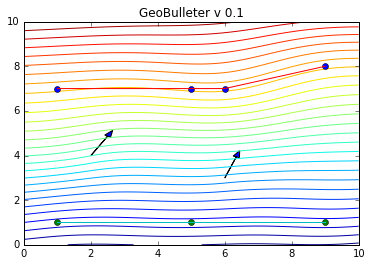

In [758]:
import matplotlib.pyplot as plt
% matplotlib inline
dip_pos_1_v = np.array([np.cos(np.deg2rad(dip_angle_1))*1,
                        np.sin(np.deg2rad(dip_angle_1))]) + dip_pos_1

dip_pos_2_v = np.array([np.cos(np.deg2rad(dip_angle_2))*1, 
                        np.sin(np.deg2rad(dip_angle_2))]) + dip_pos_2

plt.arrow(dip_pos_1[0],dip_pos_1[1], dip_pos_1_v[0]-dip_pos_1[0],
          dip_pos_1_v[1]-dip_pos_1[1], head_width = 0.2)
plt.arrow(dip_pos_2[0],dip_pos_2[1],dip_pos_2_v[0]-dip_pos_2[0], 
          dip_pos_2_v[1]-dip_pos_2[1], head_width = 0.2)

plt.plot(layer_1[:,0],layer_1[:,1], "o")
plt.plot(layer_2[:,0],layer_2[:,1], "o")

plt.plot(layer_1[:,0],layer_1[:,1], )
plt.plot(layer_2[:,0],layer_2[:,1], )

plt.contour( sol.reshape(50,50) ,30,extent = (0,10,0,10) )
#plt.colorbar()
#plt.xlim(0,10)
#plt.ylim(0,10)
plt.title("GeoBulleter v 0.1")
print (dip_pos_1_v, dip_pos_2_v, layer_1)

In [443]:
n = 10
#a = T.horizontal_stack(T.vertical_stack(T.ones(n),T.zeros(n)), T.vertical_stack(T.zeros(n), T.ones(n)))
a = T.zeros(n)

print (a.eval())
#U_G = T.horizontal_stack(([T.ones(n),T.zeros(n)],[T.zeros(n),T.ones(n)]))

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [6]:
T.stack?ö+aeg

In [ ]:
_squared_euclidean_distances2 = T.sqrt(
            (dips ** 2).sum(1).reshape((dips.shape[0], 1)) + (aux_Y ** 2).sum(1).reshape(
                (1, aux_Y.shape[0])) - 2 * dips.dot(aux_Y.T))

        _squared_euclidean_distances3 = T.sqrt(
            (dips ** 2).sum(1).reshape((dips.shape[0], 1)) + (aux_X ** 2).sum(1).reshape(
                (1, aux_X.shape[0])) - 2 * dips.dot(aux_X.T))

        h3 = T.vertical_stack(
            (dips[:, 0] - aux_Y[:, 0].reshape((aux_Y[:, 0].shape[0], 1))).T,
            (dips[:, 1] - aux_Y[:, 1].reshape((aux_Y[:, 1].shape[0], 1))).T
        )


        h4 = T.vertical_stack(
            (dips[:, 0] - aux_X[:, 0].reshape((aux_X[:, 0].shape[0], 1))).T,
            (dips[:, 1] - aux_X[:, 1].reshape((aux_X[:, 1].shape[0], 1))).T)

        r_3 = T.tile(_squared_euclidean_distances2, (2, 1))  # Careful with the number of dimensions
        r_4 = T.tile(_squared_euclidean_distances3, (2, 1))  # Careful with the number of dimensions

        _ans_d1_3 = (r_3 < self.a) * (
            -7 * (self.a - r_3) ** 3 * r_3 * (8 * self.a ** 2 + 9 * self.a * r_3 + 3 * r_3 ** 2) * 1) 
        / (4 * self.a ** 7)

        _ans_d1_4 = (r_4 < self.a) * (
            -7 * (self.a - r_4) ** 3 * r_4 * (8 * self.a ** 2 + 9 * self.a * r_4 + 3 * r_4 ** 2) * 1) 
        / (4 * self.a ** 7)

        _C_GI = (h3 / r_3 * _ans_d1_3 - h4 / r_4 * _ans_d1_4).T

        self._f_CGI = theano.function([dips, aux_X, aux_Y], _C_GI)

In [67]:
import geomodeller_xml_obj
data = geomodeller_xml_obj.GeomodellerClass()
data.load_geomodeller_file('/home/bl3/PycharmProjects/Temp_SandstoneCopy/Temp_SandstoneCopy.xml')
section_elements = data.get_sections() # This reads geomodeller sections. Each section one object

data.get_formation_point_data(section_elements[0])
points_elements = [data.get_formation_point_data(i) for i in section_elements]
print (points_elements[0][0])
points_coord = data.get_point_coordinates(points_elements[0][0])

importlib.reload(geomodeller_xml_obj)

data = geomodeller_xml_obj.GeomodellerClass()
data.load_geomodeller_file('/home/bl3/PycharmProjects/Temp_SandstoneCopy/Temp_SandstoneCopy.xml')
section_dict = data.create_sections_dict()
contact_points_dict = {}
foliation_dict = {}
for i in range(len(section_dict)):
    print ("\n\n\n", next (iter (section_dict.values())), "\n")
    print ("Elements and their ID \n")
    contact_points = data.get_formation_point_data( next (iter (section_dict.values())))

    try:
        for contact_point in contact_points:
            contact_points_dict[contact_point.get("ObservationID")] = contact_point
            print (contact_point, contact_point.get("ObservationID"))
    except TypeError:
        print ("No contact points in the section")
    #ObsID = contact_points.get("ObservationID")
    foliations = data.get_foliations( next (iter (section_dict.values())))
    try:
        for foliation in foliations:
            # dictionary to access with azimth name
            foliation_dict[foliation.get("ObservationID")+"_a"] = foliation
            # dictionary to access with dip name
            foliation_dict[foliation.get("ObservationID")+"_d"] = foliation
            print (foliation, foliation.get("ObservationID"))

    except TypeError:
        print ("No foliation in the section")
    try:
        coord_interface = data.get_point_coordinates(contact_points)
    except TypeError:
        print ("Element does not have iterable objects")

    print ("\nDictionaries:\n ", contact_points_dict, "\n", foliation_dict)

    print ("\n Contact points", contact_points, "\n", coord_interface, "\n")

    print ("foliations" , foliations,  "\n")
    try:
        for i in range(len(foliations)):
            print ("azimut:",data.get_foliation_azimuth(foliations[i]))
            print ("dip",data.get_foliation_dip(foliations[i]))
            print ("coordinates", data.get_foliation_coordinates(foliations[i]))
    except TypeError:
        print ("No foliation in the section")




 <Element '{http://www.geomodeller.com/geo}Section' at 0x7f9624974f48> 

Elements and their ID 

<Element '{http://www.geomodeller.com/geo}Interface' at 0x7f9624970098> SM_Seis_E
<Element '{http://www.geomodeller.com/geo}Interface' at 0x7f96249701d8> SM_Seis_C
<Element '{http://www.geomodeller.com/geo}Foliation' at 0x7f9624970368> SM_Seis_Ori_C
<Element '{http://www.geomodeller.com/geo}Foliation' at 0x7f96249704f8> SM_Seis_Ori_E
<Element '{http://www.geomodeller.com/geo}Foliation' at 0x7f9624970688> SM_Seis_Ori_W

Dictionaries:
  {'SM_Seis_E': <Element '{http://www.geomodeller.com/geo}Interface' at 0x7f9624970098>, 'SM_Seis_C': <Element '{http://www.geomodeller.com/geo}Interface' at 0x7f96249701d8>} 
 {'SM_Seis_Ori_E_d': <Element '{http://www.geomodeller.com/geo}Foliation' at 0x7f96249704f8>, 'SM_Seis_Ori_W_a': <Element '{http://www.geomodeller.com/geo}Foliation' at 0x7f9624970688>, 'SM_Seis_Ori_W_d': <Element '{http://www.geomodeller.com/geo}Foliation' at 0x7f9624970688>, 'SM_Seis_